# Cat and Dog Classification


![cover_img.PNG](attachment:cover_img.PNG)

## Problem Statement :
> This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset.

## Dataset : 
> The 786M ZIP archive of the raw data from [kaggle](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip) content cat and dog images

## Evaluation Metrics : 
> Accuracy, Precision, Recall, F1-Score :

## Imoprt Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
print("Libraries Imported")

Libraries Imported


# Step1 :  Load the data

### => Colab

***Step-1: create .kaggle directory

!mkdir ~/.kaggle

***Step-2: create a API token in your kaggle account.

* Upload this token("kaggle.json") on any folder here.move this file into ~/.kaggle.
* Below code is for moving ".json" file
!mv /content/sample_data/kaggle.json ~/.kaggle/kaggle.json


***Step-3: give authorization to KaggleApi

from kaggle.api.kaggle_api_extended import KaggleApi
* api = KaggleApi()
* api.authenticate()

!chmod 600 ~/.kaggle/kaggle.json


***Step-4: Download datasets from kaggle using API

!kaggle competitions download -c dogs-vs-cats

***unzip the dataset

from zipfile import ZipFile

* zf = ZipFile('/content/train.zip')
* zf.extractall('/content/sample_data') #save files in selected folder
* zf.close()

filenames = os.listdir("/content/sample_data/train")


### => Kaggle

In [2]:
# unzip the dataset
from zipfile import ZipFile
tn = ZipFile('../input/dogs-vs-cats/train.zip')
tn.extractall('/kaggle/working/') # save files in selected folder
tn.close()
print("Train Data Loaded")

tt = ZipFile('../input/dogs-vs-cats/test1.zip')
tt.extractall('/kaggle/working/') # save files in selected folder
tt.close()
print("Test Data Loaded")

Train Data Loaded
Test Data Loaded


In [3]:
train_file_path = "/kaggle/working/train"
test_file_path = "/kaggle/working/test1"

train_filenames = os.listdir(train_file_path)
test_filenames = os.listdir(test_file_path)

### => Locally

train_filenames = os.listdir(train_file_path)
train_file_path = "data/train"

test_filenames = os.listdir("data/test")
test_file_path = "data/test"

# Step2 :  Explore dataset

Here we will create dataframe which will store all file names in "filenames" column and value "1" for "dog" and "0" for "cat".

In [4]:
categories = []
for name in train_filenames:
    category = name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

image_df = pd.DataFrame({
    'filename': train_filenames,
    'category': categories
})

In [5]:
# See top 5 rows of the dataset
image_df.head()

,filename,category
0,dog.12384.jpg,1
1,cat.2548.jpg,0
2,cat.3329.jpg,0
3,dog.7270.jpg,1
4,cat.8258.jpg,0


In [6]:
image_df.shape

(25000, 2)

**See same image shape**

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for n in range(5):
    v = str(n)
    v1 = '.'+v+'.jpg'
    #print(v1)
    img = mpimg.imread(train_file_path +'/cat'+v1)
    
    print(img.shape)

(374, 500, 3)
(280, 300, 3)
(396, 312, 3)
(414, 500, 3)
(375, 499, 3)


> This prove that images don't have same shape and we have to harmonize it beause the model can not be train with image with different shape

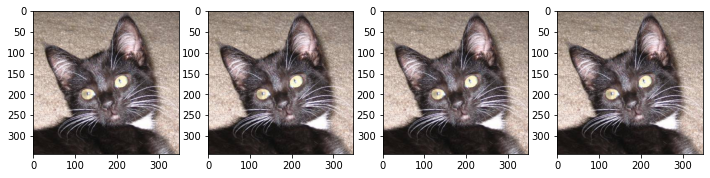

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    for n in range(3):
        v = str(102)
        v1 = '.'+v+'.jpg'
        #print(v1)
        img = mpimg.imread(train_file_path +'/cat'+v1)
    plt.imshow(img)

**Class Balancing**

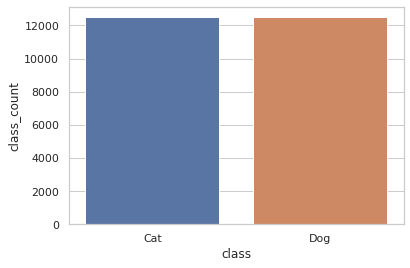

In [9]:
categ = image_df['category'].value_counts()
class_count = pd.DataFrame({'class':['Cat', 'Dog'], 
                            'class_count':[categ[1], categ[0]]})

sns.set(style='white', context='notebook', palette='Paired') 
plt.figure()
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="class", y="class_count", data=class_count)
plt.savefig("output/cl_balance_bar.png")

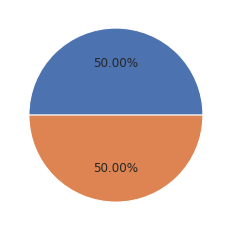

In [10]:
plt.figure()
plt.pie(x="class_count", data=class_count, autopct='%.2f%%')
plt.savefig("output/cl_balance_pie.png")
plt.show()

> classes are evenly distributed (50% dog and 50% cat)

# Step3 : Preprocess data

**3.1. Define Constants**

In [11]:
fast_run = False
img_width=180
img_height=180
img_size=(img_width, img_height)
img_channel=3
batch_size=32

**3.2. replace 0 as "cat" & 1 as "dog"**

In [12]:
image_df["category"] = image_df["category"].replace({0: 'cat', 1: 'dog'})

**3.3. split the dataset for training & validation set**

In [127]:
train_df, val_df = train_test_split(image_df, test_size=0.20, random_state=23)
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
train_df, test_df = train_test_split(train_df, test_size=0.10, random_state=23)
train_df = train_df.reset_index(drop=True)
test_df   = test_df.reset_index(drop=True)

train_df_size = train_df.shape[0]
val_df_size   = val_df.shape[0]
test_df_size   = test_df.shape[0]

print(f"Training size : {train_df_size}; Validation size : {val_df_size}; Testing size : {test_df_size}")

Training size : 18000; Validation size : 5000; Testing size : 2000


**3.4. Generate a Dataset**

In [128]:
#Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Training Generator
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_file_path, 
    x_col='filename',
    y_col='category',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size
)

# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    val_df, 
    train_file_path, 
    x_col='filename',
    y_col='category',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size
)

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    train_file_path,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 18000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames.


In [90]:
test_df

,filename,category
0,dog.1730.jpg,dog
1,dog.1106.jpg,dog
2,cat.1101.jpg,cat
3,dog.9750.jpg,dog
4,dog.3403.jpg,dog
...,...,...
1995,cat.7017.jpg,cat
1996,dog.7322.jpg,dog
1997,dog.876.jpg,dog
1998,dog.9053.jpg,dog


**3.5. Visualize datageneration effect**

In [15]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
     train_file_path, 
    x_col='filename',
    y_col='category',
    target_size=img_size,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


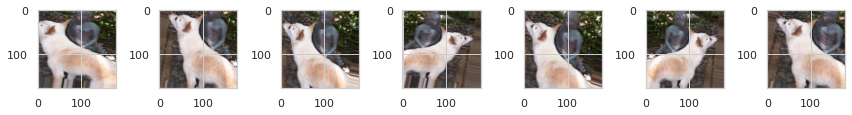

In [16]:
# visualize generated images from one image
plt.figure(figsize=(12, 12))
for i in range(0, 7):
    plt.subplot(1, 7, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Step4 : Build and Train the Model

In [17]:
# initializing the CNN
model = Sequential()

# Convolution layer-1
model.add(Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(img_width, img_height, img_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolution layer-2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolution layer-3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flattening layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# summary of model
#model.summary()

## => Model Architecture

In [18]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 178, 178, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 87, 87, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0

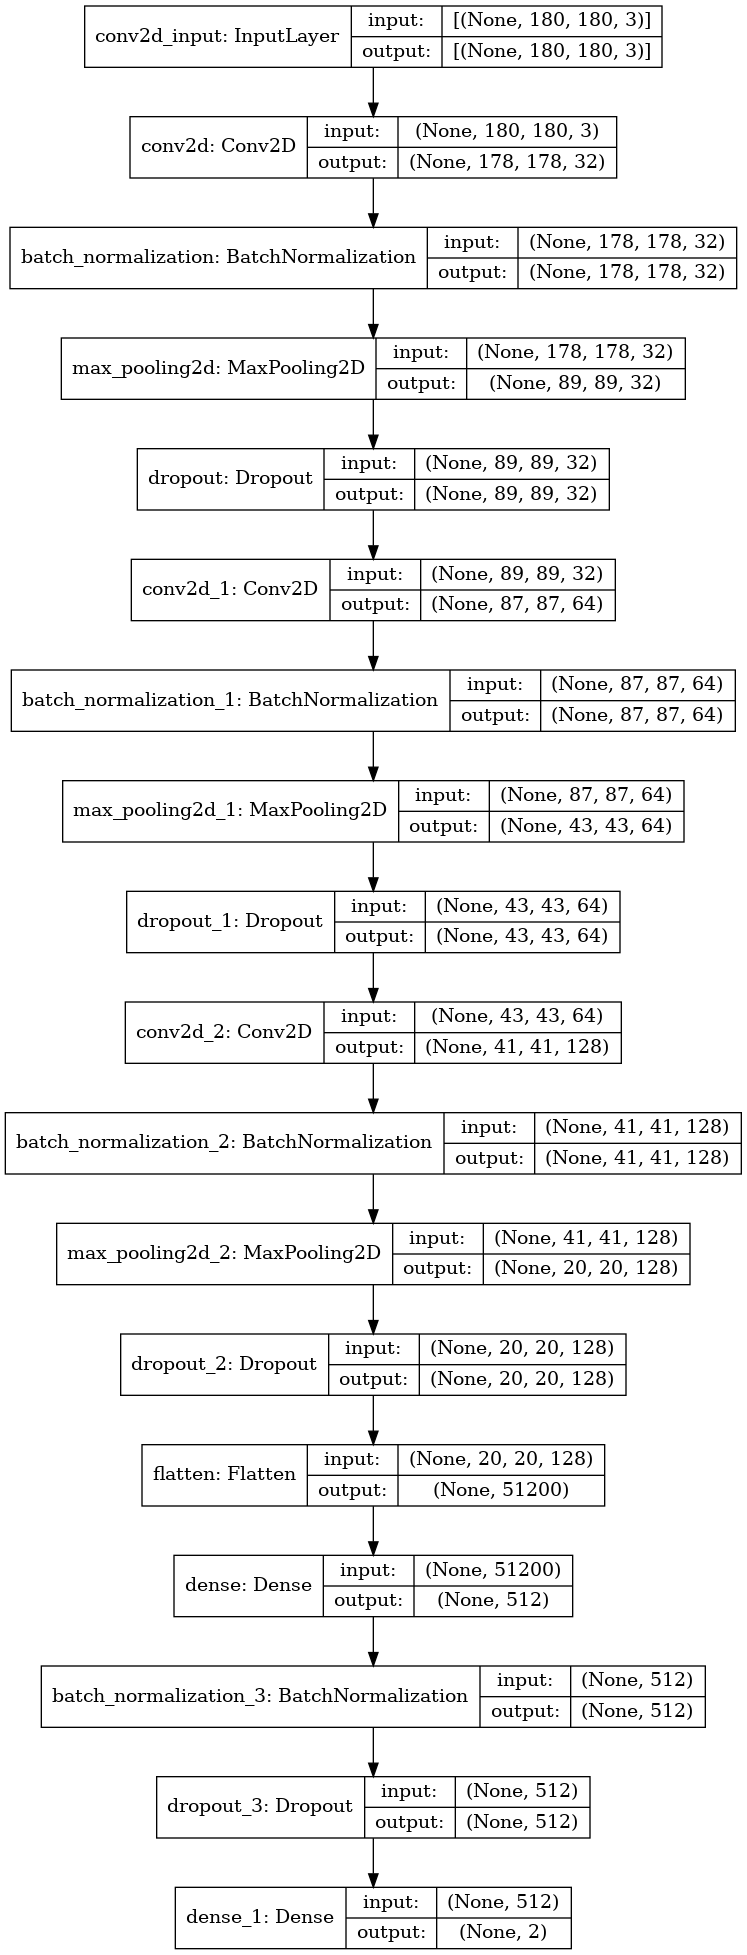

In [19]:
keras.utils.plot_model(model, to_file='output/model_plot1.png', show_shapes=True, show_layer_names=True)

## => Model Compilation

In [20]:
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['accuracy'])

## => Callback Functions
callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. For more about callback function click [Here](https://keras.io/api/callbacks/) or [Here](https://www.kdnuggets.com/2019/08/keras-callbacks-explained-three-minutes.html)

In [21]:
# EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

# ModelCheckPoint

'''
This callback saves the model after every epoch.The model'll save in a 
particular location with minimun 'val_loss'.
'''
checkPoint = keras.callbacks.ModelCheckpoint(filepath="/content/sample_data/cd_model.h5",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

# ReduceLROnPlateau
'''
It reduces learning rate when a metric has stopped improving. 
'''
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# TBoard = tf.keras.callbacks.TensorBoard(log_dir='./logs')

callbacks = [earlystop , checkPoint, learning_rate_reduction]

## => Calculate Training Duration

In [22]:
# this code is to show how much time required to train the model using different algorithms
from datetime import datetime
def timer(start_time= None):
  if not start_time:
    start_time=datetime.now()
    return start_time
  elif start_time:
    thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
    tmin,tsec=divmod(temp_sec,60)
    print('\n Time taken: %i hours %i minutes and %s seconds. '% (thour,tmin,round(tsec,2)))

## => Model Training

In [23]:
start_time=timer(None)
epochs=3 if fast_run else 40   
classifier = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=val_df_size//batch_size,
    steps_per_epoch=train_df_size//batch_size,
    callbacks=callbacks
)
timer(start_time)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
625/625 [==============================] - 228s 350ms/step - loss: 0.9905 - accuracy: 0.6040 - val_loss: 0.5560 - val_accuracy: 0.7103

Epoch 00001: val_loss improved from inf to 0.55604, saving model to /content/sample_data/cd_model.h5
Epoch 2/40
625/625 [==============================] - 216s 346ms/step - loss: 0.5512 - accuracy: 0.7262 - val_loss: 0.4795 - val_accuracy: 0.7720

Epoch 00002: val_loss improved from 0.55604 to 0.47948, saving model to /content/sample_data/cd_model.h5
Epoch 3/40
625/625 [==============================] - 218s 348ms/step - loss: 0.4884 - accuracy: 0.7641 - val_loss: 0.4461 - val_accuracy: 0.8093

Epoch 00003: val_loss improved from 0.47948 to 0.44614, saving model to /content/sample_data/cd_model.h5
Epoch 4/40
625/625 [==============================] - 218s 348ms/step - loss: 0.4404 - accuracy: 0.8003 - val_loss: 0.6583 - val_accuracy: 0.7163

Epoch 00004: val_loss did not improve from 0.44614
Epoch 5/40
625/625 [==============================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



625/625 [==============================] - 201s 322ms/step - loss: 0.2056 - accuracy: 0.9139 - val_loss: 0.1826 - val_accuracy: 0.9337

Epoch 00032: val_loss improved from 0.18350 to 0.18263, saving model to /content/sample_data/cd_model.h5
Epoch 33/40
625/625 [==============================] - 200s 320ms/step - loss: 0.2171 - accuracy: 0.9110 - val_loss: 0.1848 - val_accuracy: 0.9331

Epoch 00033: val_loss did not improve from 0.18263
Epoch 34/40
625/625 [==============================] - 208s 333ms/step - loss: 0.2149 - accuracy: 0.9133 - val_loss: 0.1851 - val_accuracy: 0.9305

Epoch 00034: val_loss did not improve from 0.18263
Epoch 35/40
625/625 [==============================] - 206s 330ms/step - loss: 0.2124 - accuracy: 0.9144 - val_loss: 0.1833 - val_accuracy: 0.9339

Epoch 00035: val_loss did not improve from 0.18263
Epoch 36/40
603/625 [===========================>..] - ETA: 6s - loss: 0.2216 - accuracy: 0.9076

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### Time taken: 6 hours 52 minutes and 2.91 seconds. 

# Step5 : Model Evalution

### ==> Visualize training accuracy and loss

In [24]:
# list all data in history
print(classifier.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


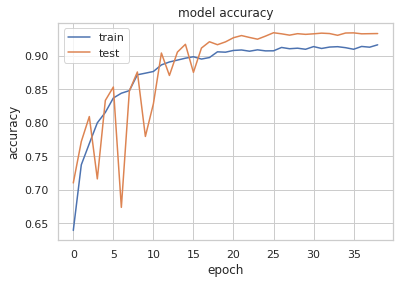

In [25]:
# summarize history for accuracy
plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("output/model_accuracy.png")
plt.show()

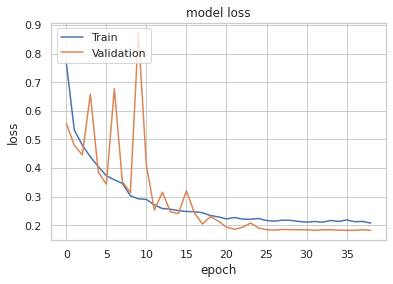

In [26]:
# summarize history for loss
plt.plot(classifier.history['loss'])
plt.plot(classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("output/model_loss.png")
plt.show()

### ==> Training, Validation  Accuracy and Generalization Error

In [71]:
print("Evaluation on training set")
print("============================")
score_train = model.evaluate(train_generator,  verbose=0)
print('Train loss         :', score_train[0])
print('Train accuracy     : %.2f%% ' % round(score_train[1]*100,2),'\n')

print("Evaluation on testing set")
print("============================")
score_test = model.evaluate(test_generator,  verbose=0)
print('Test loss           :', score_test[0])
print('Test accuracy       : %.2f%% '% round(score_test[1]*100,2), '\n')
print("Generalization Error")

print("============================")
print("Generalization Error: %.2f%%" % (100-score_test[1]*100))


Evaluation on training set
Train loss         : 0.165281280875206
Train accuracy     : 93.91%  

Evaluation on testing set
Test loss           : 0.13799293339252472
Test accuracy       : 95.40%  

Generalization Error
Generalization Error: 4.60%


# Step6 : Prediction
### Run inference on new data

**6.1. Prepare Testing Data**

# create a dataframe and store all image files
test_filenames = os.listdir(test_file_path)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
test_df.head()

**6.2. Create Testing Generator**

In [29]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator12 = test_gen.flow_from_dataframe(
    test_df, 
    test_file_path,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [125]:
test_generator

**6.3. Find Prediction**

In [129]:
# find prediction using predict_generator
predict = model.predict_generator(test_generator, 
                                  steps=np.ceil(nb_samples/batch_size))

# here "category" column store the index of higher predicted value
test_df['category1'] = np.argmax(predict, axis=-1)

# here predicted value will replace by "cat" for 0 & "dog" for 1
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category1'] = test_df['category1'].replace(label_map)

# See predicted dataframe
test_df.head()

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


,filename,category,category1
0,dog.1730.jpg,dog,dog
1,dog.1106.jpg,dog,dog
2,cat.1101.jpg,cat,cat
3,dog.9750.jpg,dog,dog
4,dog.3403.jpg,dog,dog


**6.4. Visualize Result**

In [130]:
# see how many images classify into which class 
test_df['category'].value_counts()#.plot.bar()

dog    1040
cat     960
Name: category, dtype: int64

In [131]:
test_df['category1'].value_counts()#.plot.bar()

dog    1040
cat     960
Name: category1, dtype: int64

**6.5.  See Predicted Image With Images**

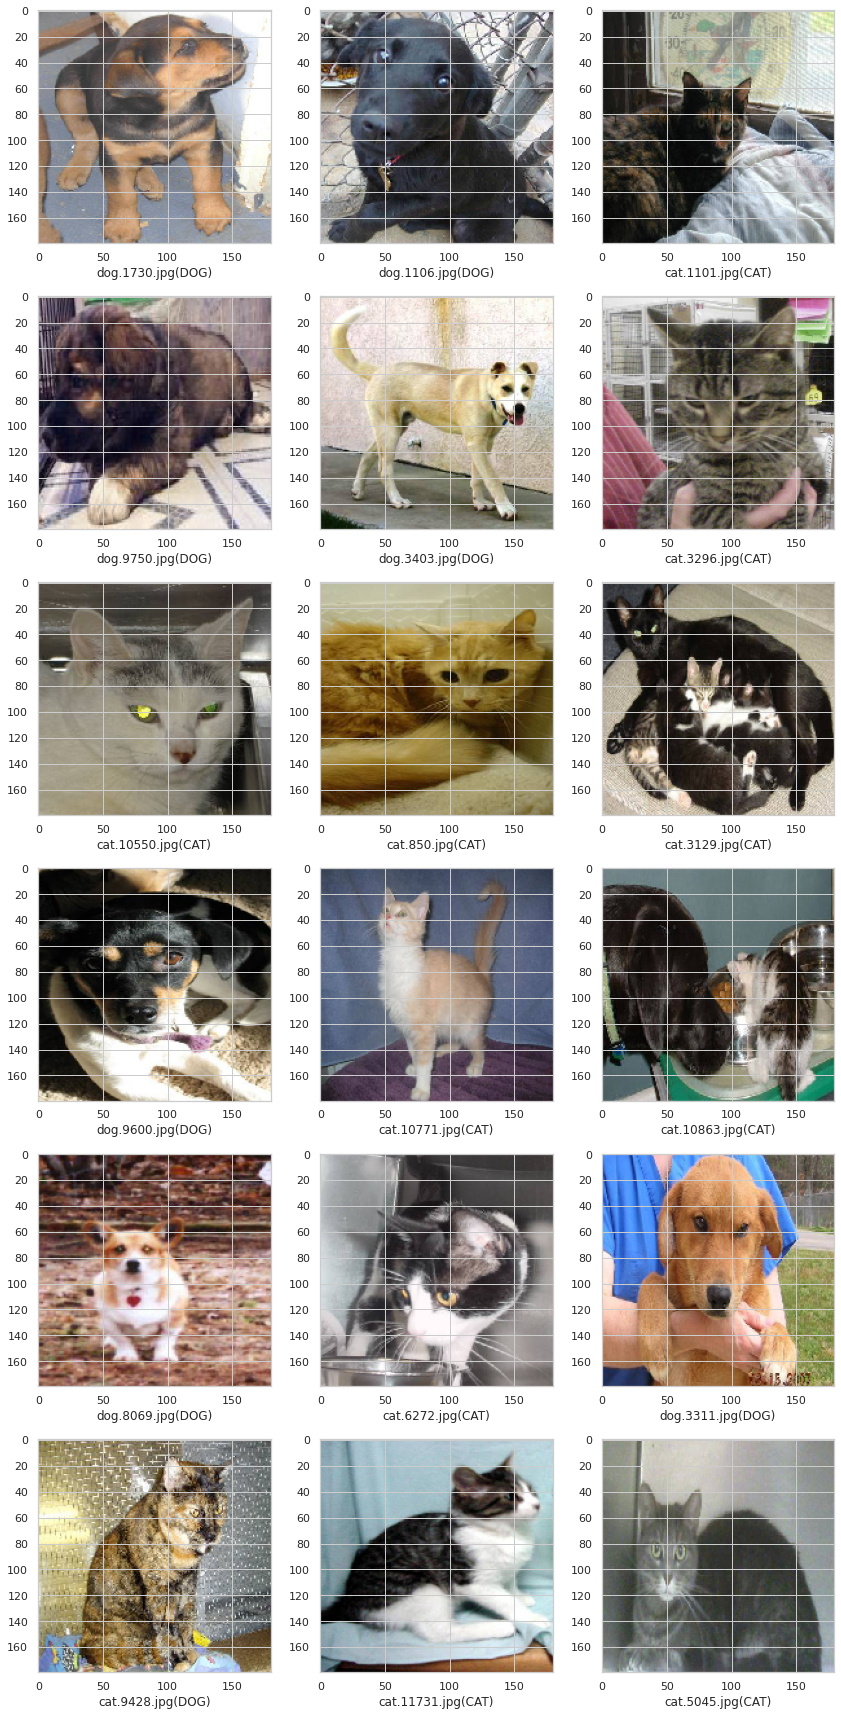

In [109]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(train_file_path+"/"+filename, target_size=img_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category.upper()) + ')' )
plt.tight_layout()
plt.show()


**6.6. Confusion Matrix**

In [110]:
# Look at confusion matrix 
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

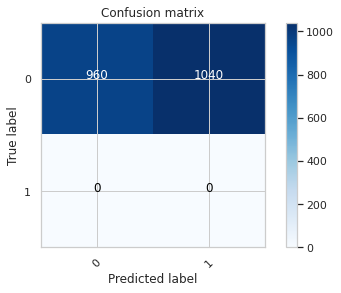

In [113]:
# Look at confusion matrix 
from sklearn.metrics import confusion_matrix

#y_test = pd.read_csv("../input/dogs-vs-cats/sampleSubmission.csv")
Y_pred = predict #model.predict(test_df)
# Convert vto one hot vectors
predicted_value = np.argmax(predict,axis = 1) 
true_value = np.argmax(test_df[['category']],axis = 1) 

confusion_mtx = confusion_matrix(true_value, predicted_value) 
plot_confusion_matrix(confusion_mtx, classes = range(2))



**6.7. Classification Report**

In [114]:
from sklearn.metrics import classification_report
true_pred =pd.DataFrame({"True_value":true_value['category'],
                         "Predicted_value":predicted_value})
target_names = ['Cat', 'Dog']
print(classification_report(true_pred["True_value"], true_pred["Predicted_value"], target_names=target_names))

              precision    recall  f1-score   support

         Cat       1.00      0.48      0.65      2000
         Dog       0.00      0.00      0.00         0

    accuracy                           0.48      2000
   macro avg       0.50      0.24      0.32      2000
weighted avg       1.00      0.48      0.65      2000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**6.8 Calculating Sensitivity and Specificity**

In [115]:
def pred_eval(cm):
    TP, FP, FN, TN = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    total = sum(sum(cm))
    accuracy    = (TP+TN)/total
    
    precision   = TP/(TP + FP)
    recall      = TP/(TP + FN)
    sensitivity = TP/(TP + FP)
    specificity = TN/(TN + FN)
    f1 = 2*precision*recall/(precision + recall)
    eval = pd.DataFrame({"Metric":["Accuracy","Precision", "Recall", "Sensitivity", "Specificity", "F1" ],
                 "Score":[accuracy,precision, recall, sensitivity, specificity, f1 ]})
    return eval

In [116]:
metrics = pred_eval(confusion_mtx)
metrics.T

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


,0,1,2,3,4,5
Metric,Accuracy,Precision,Recall,Sensitivity,Specificity,F1
Score,0.48,0.48,1.0,0.48,NaN,0.648649


**6.8. Infer on single image**

In [59]:
img = keras.preprocessing.image.load_img(
    "train_file_path/cat.0.jpg", target_size=img_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0][0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

FileNotFoundError: [Errno 2] No such file or directory: 'train_file_path/cat.0.jpg'

## Step7 : Save the model

In [ ]:
model.save('models/cat_dog_classify.h5')
print("Saving the model as mnist.h5")

In [ ]:
rom keras.models import load_model
new_model = load_model('models/cat_dog_classify.h5')

# Step8 : Improve the model

A few things could be done to improve the results:

+ Different model architecture (num of nodes, etc)
+ Dropout
+ Adaptive learning rate
+ Data Augmentation
+ and more

# Step9 : Model Deployment

* With opencv
* Tkinter
* Flask
* Streamlit

# Kaggle Submission

In [ ]:
results =[]
for index in range(28000):
    img = test_data[index].reshape(1, 28, 28, 1)
    pred = np.argmax(model.predict(img))
    results.append(pred)

In [ ]:
submission = pd.DataFrame()
submission['ImageId'] = [i for i in range(1, 28001)]
submission['Label'] = results

In [ ]:
submission.to_csv('./my_submission.csv', index=False)

credit : https://www.kaggle.com/sidharth178/cat-dog-classification-flask-app

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, to_file='output/model_plot.png', show_shapes=True, show_layer_names=True)